### Dependencies
Here we import the modules and keys used in the program. 

In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import gmaps
import os
import json

from random import seed
from random import random
from random import randint
from random import choice
from citipy import citipy
from scipy.stats import linregress

# API Keys
from config import (weather_key, gkey)
# Configure gmaps
gmaps.configure(api_key=gkey)

Function to get city nearest a coordinate value using citipy library

In [2]:
def get_nearest_city(latitude, longitude):
    # latitude : type = float . The latitude to search nearest city
    # longitude: type = float . The longitude to search nearest city
    city = citipy.nearest_city(latitude, longitude)
    return(city)

Using Gmaps Geocoding , get the actual coordinates for the input city

In [3]:
def get_actual_coords(city):
    base_url    = "https://maps.googleapis.com/maps/api/geocode/json"
    params      = {"address": city.city_name + ","  + city.country_code, 
                   "key"    : gkey}
    try:
        result      = requests.get(base_url, params=params).json()
        latitude    = result["results"][0]["geometry"]["location"]["lat"]
        longitude   = result["results"][0]["geometry"]["location"]["lng"]
        city_coords = tuple([latitude, longitude])
        return(city_coords)
    except:     
        print(" Error in get_actual_coords for city %s" % city.city_name)
        return (-1)

Generate a random longitude value

In [4]:
def generate_long():
    # Generates a random longitude
    rand = random()
    intermediate = ( -180 + ((180)*rand))
    the_sign = choice([-1,1])
    longitude = intermediate * the_sign
    return(longitude)

Generate a random longitude value

In [5]:
def generate_lat():
    # Generates a random latitude
    rand = random()
    intermediate = ( -90 + ((90)*rand))
    the_sign = choice([-1,1])
    latitude = intermediate * the_sign
    return(latitude)

In [6]:
def print_attributes(obj):
    #Utility for printing an object's attributes
    for attr in vars(obj):

        print(attr, getattr(obj, attr))

Gets a list of 700 cities by generating random coordinates and getting the nearest city via function getCities()

In [7]:
def getCities(): 
    #Create tuples ( id, name, country, latitude, longitude)
    MAX_CITY_COUNT = 700
    x = 1
    cities = []
    while True:
        city = get_nearest_city(generate_lat(), generate_long())
        coords = get_actual_coords(city)
        if (coords != -1):
            t = tuple( [x, city.city_name, city.country_code.upper(), {"lon":coords[1],"lat":coords[0]} ] )
            cities.append(t)
            x += 1;
        if (len(cities) > MAX_CITY_COUNT):
            break;

        df = pd.DataFrame(cities, columns =['id', 'name', 'country', 'coord']) 
        return(df)

### Data Sources
In this version, we use three data sources: 
* A list of 700 cities, randomly selected using the [citypy](https://github.com/wingchen/citipy) library.
* A list of country codes and names, downloaded from https://datahub.io/core/country-listlibraryone 
* The weather at each of the 700 cities, obtained via service calls to `openweather.com`

We merge the list of cities with the country codes, to have the city names and their country names in one single dataframe. 

In [21]:
cities_pd = getCities()

# Import the country codes file to get the country names.
filepath = "countryCodes.json"
countryCodes = pd.read_json(filepath, orient="index", encoding="utf-8" )
countryCodes.index.rename("country", inplace=True)
countryCodes.columns=["Country Name"]

# Merge the city list with the country names data frames:
merged_data = cities_pd.merge(countryCodes, how="inner", on="country")
merged_data.head(20)

 Error in get_actual_coords for city lolua
 Error in get_actual_coords for city lubu
 Error in get_actual_coords for city malm
(1, 'punta arenas', 'CL', {'lon': -70.9170683, 'lat': -53.1638329})


,id,name,country,coord,Country Name
0,1,punta arenas,CL,"{'lon': -70.9170683, 'lat': -53.1638329}",Chile
1,35,punta arenas,CL,"{'lon': -70.9170683, 'lat': -53.1638329}",Chile
2,40,constitucion,CL,"{'lon': -72.41669999999999, 'lat': -35.3333000...",Chile
3,62,punta arenas,CL,"{'lon': -70.9170683, 'lat': -53.1638329}",Chile
4,73,punta arenas,CL,"{'lon': -70.9170683, 'lat': -53.1638329}",Chile
5,81,castro,CL,"{'lon': -73.7624137, 'lat': -42.4801402}",Chile
6,118,punta arenas,CL,"{'lon': -70.9170683, 'lat': -53.1638329}",Chile
7,222,castro,CL,"{'lon': -73.7624137, 'lat': -42.4801402}",Chile
8,243,punta arenas,CL,"{'lon': -70.9170683, 'lat': -53.1638329}",Chile
9,257,punta arenas,CL,"{'lon': -70.9170683, 'lat': -53.1638329}",Chile


### Fetching weather data
Here we take a random sample of 600 cities from the merged city data frame and for each one, invoke the `openweather` API service, passing in the city id as parameter.  We extract the latitute, longitude, temperature, humidity, cloudiness % and wind speed for each city and add each record to a list of weather data, that will be used in subsequent steps to produce analysis.

In [24]:
base_url = "https://api.openweathermap.org/data/2.5/weather?"
params = {"appid": weather_key,
          "units": "imperial"}
CITY_SAMPLE_SIZE=600

# Sample 600 cities and get their weather info
cities = merged_data.loc[:,["id", "name", "country", "Country Name"]].sample(CITY_SAMPLE_SIZE)

# Save each city's information in a list of dictionaries

weather_data = []

for ind in cities.index:
    print("Fetching weather for city: " , cities["name"][ind] , " in " , cities["Country Name"][ind],"...")
    try:
        params["q"] = cities["name"][ind] + "," + cities["country"][ind]
        city_weather = requests.get(base_url, params=params).json()
        if (city_weather["cod"] != 200):
            print("Weather data for %s in %s not found. Skipping." % (cities["name"][ind], cities["Country Name"][ind]) )
        else:
            weather_data.append({
                         "City ID"    : cities["id"][ind],
                         "Lat"        : city_weather["coord"]["lat"],
                         "Lon"        : city_weather["coord"]["lon"],
                         "Temp"       : city_weather["main"]["temp"],
                         "Humidity"   : city_weather["main"]["humidity"],
                         "Cloudiness" : city_weather["clouds"]["all"],
                         "Wind Speed" : city_weather["wind"]["speed"]
                        })
    except: 
        print("Error while fetching data for %s in %s not found. Skipping." , (cities["name"][ind], cities["Country Name"][ind]) ) 
    
    print( len(weather_data), ' weather records found.') 

Fetching weather for city:  ushuaia  in  Argentina ...
1  weather records found.
Fetching weather for city:  albany  in  Australia ...
2  weather records found.
Fetching weather for city:  okhotsk  in  Russian Federation ...
3  weather records found.
Fetching weather for city:  urumqi  in  China ...
4  weather records found.
Fetching weather for city:  wanning  in  China ...
5  weather records found.
Fetching weather for city:  kaitangata  in  New Zealand ...
6  weather records found.
Fetching weather for city:  flinders  in  Australia ...
7  weather records found.
Fetching weather for city:  fairbanks  in  United States ...
8  weather records found.
Fetching weather for city:  sobolevo  in  Russian Federation ...
9  weather records found.
Fetching weather for city:  kuytun  in  China ...
Weather data for kuytun in China not found. Skipping.
9  weather records found.
Fetching weather for city:  werda  in  Botswana ...
10  weather records found.
Fetching weather for city:  boyolangu  in

84  weather records found.
Fetching weather for city:  bluff  in  New Zealand ...
85  weather records found.
Fetching weather for city:  oak ridge  in  United States ...
86  weather records found.
Fetching weather for city:  vila velha  in  Brazil ...
87  weather records found.
Fetching weather for city:  prado  in  Brazil ...
88  weather records found.
Fetching weather for city:  chumikan  in  Russian Federation ...
89  weather records found.
Fetching weather for city:  castro  in  Chile ...
90  weather records found.
Fetching weather for city:  ribeira grande  in  Portugal ...
91  weather records found.
Fetching weather for city:  mataura  in  French Polynesia ...
Weather data for mataura in French Polynesia not found. Skipping.
91  weather records found.
Fetching weather for city:  burns lake  in  Canada ...
92  weather records found.
Fetching weather for city:  cabedelo  in  Brazil ...
93  weather records found.
Fetching weather for city:  uvalde  in  United States ...
94  weather 

155  weather records found.
Fetching weather for city:  nikolskoye  in  Russian Federation ...
156  weather records found.
Fetching weather for city:  busselton  in  Australia ...
157  weather records found.
Fetching weather for city:  new norfolk  in  Australia ...
158  weather records found.
Fetching weather for city:  rikitea  in  French Polynesia ...
159  weather records found.
Fetching weather for city:  cabo san lucas  in  Mexico ...
160  weather records found.
Fetching weather for city:  saint-philippe  in  Reunion ...
161  weather records found.
Fetching weather for city:  dzhebariki-khaya  in  Russian Federation ...
162  weather records found.
Fetching weather for city:  ushuaia  in  Argentina ...
163  weather records found.
Fetching weather for city:  albany  in  Australia ...
164  weather records found.
Fetching weather for city:  tasiilaq  in  Greenland ...
165  weather records found.
Fetching weather for city:  east london  in  South Africa ...
166  weather records found.


235  weather records found.
Fetching weather for city:  rikitea  in  French Polynesia ...
236  weather records found.
Fetching weather for city:  bambous virieux  in  Mauritius ...
237  weather records found.
Fetching weather for city:  vaini  in  Tonga ...
238  weather records found.
Fetching weather for city:  ilulissat  in  Greenland ...
239  weather records found.
Fetching weather for city:  saskylakh  in  Russian Federation ...
240  weather records found.
Fetching weather for city:  puerto ayora  in  Ecuador ...
241  weather records found.
Fetching weather for city:  san quintin  in  Mexico ...
242  weather records found.
Fetching weather for city:  victoria  in  Seychelles ...
243  weather records found.
Fetching weather for city:  kavaratti  in  India ...
244  weather records found.
Fetching weather for city:  qaanaaq  in  Greenland ...
245  weather records found.
Fetching weather for city:  itoman  in  Japan ...
246  weather records found.
Fetching weather for city:  mataura  i

323  weather records found.
Fetching weather for city:  ushuaia  in  Argentina ...
324  weather records found.
Fetching weather for city:  jimenez  in  Mexico ...
325  weather records found.
Fetching weather for city:  monrovia  in  Liberia ...
326  weather records found.
Fetching weather for city:  punta arenas  in  Chile ...
327  weather records found.
Fetching weather for city:  kuche  in  China ...
Weather data for kuche in China not found. Skipping.
327  weather records found.
Fetching weather for city:  sentyabrskiy  in  Russian Federation ...
Weather data for sentyabrskiy in Russian Federation not found. Skipping.
327  weather records found.
Fetching weather for city:  rikitea  in  French Polynesia ...
328  weather records found.
Fetching weather for city:  saint-philippe  in  Reunion ...
329  weather records found.
Fetching weather for city:  punta arenas  in  Chile ...
330  weather records found.
Fetching weather for city:  gumushane  in  Turkey ...
Weather data for gumushane 

Weather data for sentyabrskiy in Russian Federation not found. Skipping.
393  weather records found.
Fetching weather for city:  sitka  in  United States ...
394  weather records found.
Fetching weather for city:  mariental  in  Namibia ...
395  weather records found.
Fetching weather for city:  avarua  in  Cook Islands ...
396  weather records found.
Fetching weather for city:  fort nelson  in  Canada ...
397  weather records found.
Fetching weather for city:  saint-philippe  in  Reunion ...
398  weather records found.
Fetching weather for city:  mount isa  in  Australia ...
399  weather records found.
Fetching weather for city:  coihaique  in  Chile ...
400  weather records found.
Fetching weather for city:  port elizabeth  in  South Africa ...
401  weather records found.
Fetching weather for city:  rikitea  in  French Polynesia ...
402  weather records found.
Fetching weather for city:  ukiah  in  United States ...
403  weather records found.
Fetching weather for city:  champasak  i

474  weather records found.
Fetching weather for city:  beboto  in  Chad ...
475  weather records found.
Fetching weather for city:  carnarvon  in  Australia ...
476  weather records found.
Fetching weather for city:  yellowknife  in  Canada ...
477  weather records found.
Fetching weather for city:  qaanaaq  in  Greenland ...
478  weather records found.
Fetching weather for city:  rikitea  in  French Polynesia ...
479  weather records found.
Fetching weather for city:  atuona  in  French Polynesia ...
480  weather records found.
Fetching weather for city:  bambous virieux  in  Mauritius ...
481  weather records found.
Fetching weather for city:  severo-kurilsk  in  Russian Federation ...
482  weather records found.
Fetching weather for city:  bagdarin  in  Russian Federation ...
483  weather records found.
Fetching weather for city:  punta arenas  in  Chile ...
484  weather records found.
Fetching weather for city:  jamestown  in  Saint Helena ...
485  weather records found.
Fetching 

### Save weather data to a file
We then convert the `weather_data[]` list to a Pandas DataFrame, and save it to a local `*.csv` file. 

In [25]:
#Create a data frame for the data and save to CSV file
weather_df = pd.DataFrame(weather_data)
weather_df = weather_df.set_index("City ID")
weather_df.to_csv("weather_data.csv")
weather_df.head(10)


,Lat,Lon,Temp,Humidity,Cloudiness,Wind Speed
City ID,,,,,,
426,-54.8000,-68.3000,46.40,76,75,10.36
165,-35.0169,117.8917,62.60,94,90,26.46
21,59.3833,143.3000,7.54,86,98,23.96
174,43.8010,87.6005,12.20,92,20,2.24
358,18.8003,110.3967,75.40,68,10,9.19
309,-46.2817,169.8464,66.00,75,1,7.00
443,-34.5833,150.8552,76.57,73,47,5.01
633,64.8378,-147.7164,-5.58,77,90,2.71
403,54.4299,31.8996,-6.30,91,28,7.78


## Weather Data Analysis
In this section, we create scatter plots using `matplotlib` based on the weather data.
The first chart compares the temperature with the latitude for each of the 600 cities in the sample.

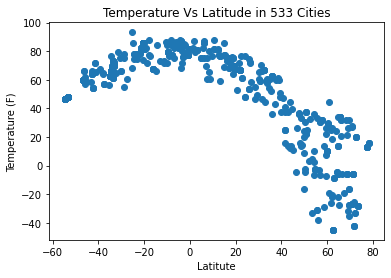

In [26]:
# Plot out temperatur versus latitute
x_values = weather_df['Lat']
y_values = weather_df['Temp']
plt.scatter(x_values,y_values)
plt.xlabel('Latitute')
plt.ylabel('Temperature (F)')
plt.title("Temperature Vs Latitude in " + str(len(x_values)) + " Cities")
plt.savefig("01_Temp_Vs_Latitudes.png")
plt.show()


The graph shows a moderate to strong negative correlation between latitude and temperature, that is, temperatures tend to be lower at higher (absolute) latitute values.  For cities in the southern hemisphere, the temperatures are much higer than for northen temperatures.  This is because the weather data was obtained during the summer season of the southern hemisphere.

Also, note that there are much more cities in the northen hemisphere than in the southern latitutes, this could be a result of the random selection picking more cities in the northen latitudes, or it could be that there are actually more cities in the north hemisphere than in the south.

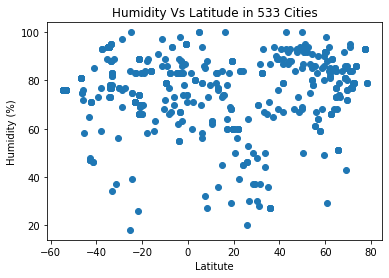

In [27]:
# Plot out humidity versus latitute
x_values = weather_df['Lat']
y_values = weather_df['Humidity']
plt.scatter(x_values,y_values)
plt.xlabel('Latitute')
plt.ylabel('Humidity (%)')
plt.title("Humidity Vs Latitude in " + str(len(x_values)) + " Cities")
plt.savefig("02_Humidity_Vs_Latitudes.png")
plt.show()

Here we compare the humidity % to the city's latitude.  Humidity seems distributed equally along all latitudes, with most values between 60 and 100%.  Again, the graph shows there are less data points for the southern latitudes. 

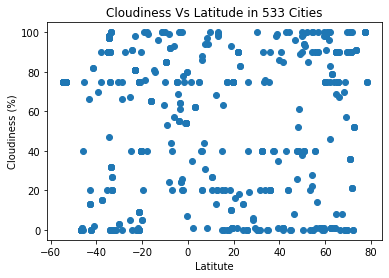

In [28]:
# Plot out Cloudiness versus latitute
x_values = weather_df['Lat']
y_values = weather_df['Cloudiness']
plt.scatter(x_values,y_values)
plt.xlabel('Latitute')
plt.ylabel('Cloudiness (%)')
plt.title("Cloudiness Vs Latitude in " + str(len(x_values)) + " Cities")
plt.savefig("03_Cloudiness_Vs_Latitudes.png")
plt.show()

Cloudiness Vs Latitude does not show a pattern, as the data points are spread throughout the whole chart.  

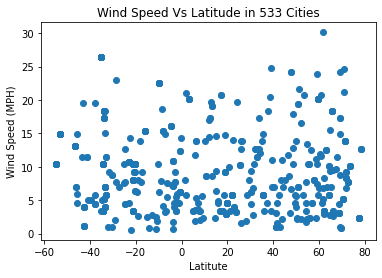

In [29]:
# Plot out Wind Speed versus latitute
x_values = weather_df['Lat']
y_values = weather_df['Wind Speed']
plt.scatter(x_values,y_values)
plt.xlabel('Latitute')
plt.ylabel('Wind Speed (MPH)')
plt.title("Wind Speed Vs Latitude in " + str(len(x_values)) + " Cities")
plt.savefig("04_Wind_Speed_Vs_Latitudes.png")
plt.show()

Comparing wind speed values with the latitude, higher values are observed at higher latitudes, and most values are between 0 and 15 mph.

---

## Southern vs. Norhten Hemispheres Analysis
In this section, we perform the same comparisons as before (Temperature, Wind Speed, Humidity and Cloudiness), but we separate the data points as coming from cities in the northen hemisphere (Latitudes > 0) and shouthern hemisphere (Latitude < 0).  Remember the data was obtained on January 2021, when it was winter in the northern latitudes and summer in the southern ones.
The steps to create these charts are:

1. Create figure with 2 subplots in matlibplot.
2. Create a dataframe for positive latitudes from the weather data (northern hemisphere)
3. Create a dataframe for negative latitudes from the weather data (souther hemisphere)
4. Run linear regression on each latitute - weather parameter (temp, wind, etc.)
5. Plot a scatter plot for the northen latitudes and another one for the southern latitudes, including the regression line.

C:\Users\joser\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\joser\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


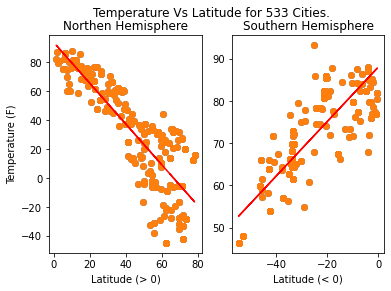

In [30]:
# Separate the weather_df data frame , creating two additional ones for each hemisphere.
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Temperature Vs Latitude for ' + str(len(x_values)) + " Cities.")
north_cities = weather_df[weather_df["Lat"] > 0]
south_cities = weather_df[weather_df["Lat"] < 0]


# Left Plot - Northen Cities
north_x_values = north_cities['Lat']
north_y_values = north_cities['Temp']

(slope, intercept, rvalue, pvalue, stderr) = linregress(north_x_values, north_y_values)
regress_values = north_x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
ax1.scatter(north_x_values,north_y_values)
ax1.plot(north_x_values,regress_values,"r-")
#ax1.annotate(line_eq,(6,10),fontsize=15,color="red")

ax1.scatter(north_x_values,north_y_values)
ax1.set_title('Northen Hemisphere')
ax1.set_ylabel('Temperature (F)')
ax1.set_xlabel('Latitude (> 0)')
fig.show()

# Right Plot - Southern Cities

#south_cities = north_cities * -1  # <<<<<<<<<<<<<<  Change this at final version
south_x_values = south_cities['Lat']
south_y_values = south_cities['Temp']

(slope, intercept, rvalue, pvalue, stderr) = linregress(south_x_values, south_y_values)
regress_values = south_x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
ax2.scatter(south_x_values,south_y_values)
ax2.plot(south_x_values,regress_values,"r-")
#ax2.annotate(line_eq,(6,10),fontsize=15,color="red")

ax2.scatter(south_x_values,south_y_values)
ax2.set_title('Southern Hemisphere')
ax2.set_xlabel('Latitude (< 0)')
plt.savefig("05_Temp_Vs_Latitudes_Multi.png")
fig.show()


For the northen hemisphere, it clear there is a strong negative correlation between temperature and latitude.  Values are more spread for the southern hemisphere, but a positive correlation is seen (higher temperatures are also found closer to the equator).  Again, we see fewer data points in the southern hemisphere.

C:\Users\joser\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\joser\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


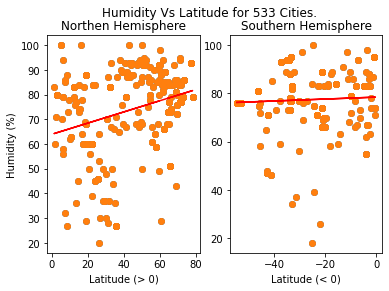

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Humidity Vs Latitude for ' + str(len(x_values)) + " Cities.")
north_cities = weather_df[weather_df["Lat"] > 0]
south_cities = weather_df[weather_df["Lat"] < 0]

# Left Plot - Northen Cities
north_x_values = north_cities['Lat']
north_y_values = north_cities['Humidity']

(slope, intercept, rvalue, pvalue, stderr) = linregress(north_x_values, north_y_values)
regress_values = north_x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
ax1.scatter(north_x_values,north_y_values)
ax1.plot(north_x_values,regress_values,"r-")
#ax1.annotate(line_eq,(6,10),fontsize=15,color="red")

ax1.scatter(north_x_values,north_y_values)
ax1.set_title('Northen Hemisphere')
ax1.set_ylabel('Humidity (%)')
ax1.set_xlabel('Latitude (> 0)')
fig.show()

# Right Plot - Southern Cities
#south_cities = north_cities * -1  # <<<<<<<<<<<<<<  Change this at final version
south_x_values = south_cities['Lat']
south_y_values = south_cities['Humidity']

(slope, intercept, rvalue, pvalue, stderr) = linregress(south_x_values, south_y_values)
regress_values = south_x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
ax2.scatter(south_x_values,south_y_values)
ax2.plot(south_x_values,regress_values,"r-")
#ax2.annotate(line_eq,(6,10),fontsize=15,color="red")

ax2.scatter(south_x_values,south_y_values)
ax2.set_title('Southern Hemisphere')
ax2.set_xlabel('Latitude (< 0)')
plt.savefig("06_Humid_Vs_Latitudes_Multi.png")
fig.show()

Here we create the same scatter plots, but the paramter analyzed is Humidity %.  Both hemispheres show a positive correlation, although it is not so strong at the southern hemisphere. 

C:\Users\joser\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\joser\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


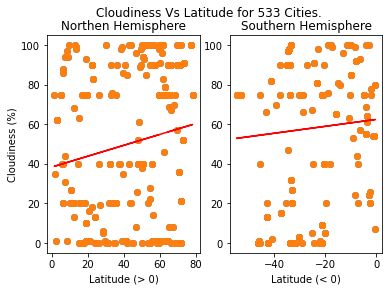

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Cloudiness Vs Latitude for ' + str(len(x_values)) + " Cities.")
north_cities = weather_df[weather_df["Lat"] > 0]
south_cities = weather_df[weather_df["Lat"] < 0]

# Left Plot - Northen Cities
north_x_values = north_cities['Lat']
north_y_values = north_cities['Cloudiness']


(slope, intercept, rvalue, pvalue, stderr) = linregress(north_x_values, north_y_values)
regress_values = north_x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
ax1.scatter(north_x_values,north_y_values)
ax1.plot(north_x_values,regress_values,"r-")
#ax1.annotate(line_eq,(6,10),fontsize=15,color="red")


ax1.scatter(north_x_values,north_y_values)
ax1.set_title('Northen Hemisphere')
ax1.set_ylabel('Cloudiness (%)')
ax1.set_xlabel('Latitude (> 0)')
fig.show()

# Right Plot - Southern Cities
#south_cities = north_cities * -1  # <<<<<<<<<<<<<<  Change this at final version
south_x_values = south_cities['Lat']
south_y_values = south_cities['Cloudiness']

(slope, intercept, rvalue, pvalue, stderr) = linregress(south_x_values, south_y_values)
regress_values = south_x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
ax2.scatter(south_x_values,south_y_values)
ax2.plot(south_x_values,regress_values,"r-")
#ax2.annotate(line_eq,(6,10),fontsize=15,color="red")

ax2.scatter(south_x_values,south_y_values)
ax2.set_title('Southern Hemisphere')
ax2.set_xlabel('Latitude (< 0)')
plt.savefig("07_Cloud_Vs_Latitudes_Multi.png")
fig.show()

The cloudiness distribution really shows no definitive pattern, althouth the regresion values indicate a positive correlation between cloudiness % and latitude.  This would suggest that the higher the latitude, the cloudier it gets. 

C:\Users\joser\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\joser\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


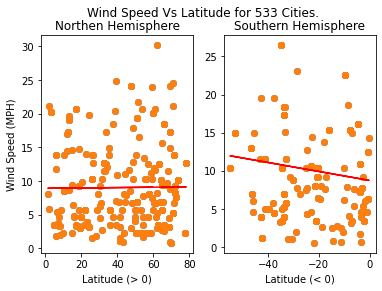

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Wind Speed Vs Latitude for ' + str(len(x_values)) + " Cities.")
north_cities = weather_df[weather_df["Lat"] > 0]
south_cities = weather_df[weather_df["Lat"] < 0]

# Left Plot - Northen Cities
north_x_values = north_cities['Lat']
north_y_values = north_cities['Wind Speed']

(slope, intercept, rvalue, pvalue, stderr) = linregress(north_x_values, north_y_values)
regress_values = north_x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
ax1.scatter(north_x_values,north_y_values)
ax1.plot(north_x_values,regress_values,"r-")
#ax1.annotate(line_eq,(6,10),fontsize=15,color="red")

ax1.scatter(north_x_values,north_y_values)
ax1.set_title('Northen Hemisphere')
ax1.set_ylabel('Wind Speed (MPH)')
ax1.set_xlabel('Latitude (> 0)')
fig.show()

# Right Plot - Southern Cities
#south_cities = north_cities * -1  # <<<<<<<<<<<<<<  Change this at final version
south_x_values = south_cities['Lat']
south_y_values = south_cities['Wind Speed']

(slope, intercept, rvalue, pvalue, stderr) = linregress(south_x_values, south_y_values)
regress_values = south_x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
ax2.scatter(south_x_values,south_y_values)
ax2.plot(south_x_values,regress_values,"r-")
#ax2.annotate(line_eq,(6,10),fontsize=15,color="red")

ax2.scatter(south_x_values,south_y_values)
ax2.set_title('Southern Hemisphere')
ax2.set_xlabel('Latitude (< 0)')
plt.savefig("08_Wind_Vs_Latitudes_Multi.png")
fig.show()

Wind speed analysis also shows no definitive pattern, although linear regression says wind speeds are lower closer to the equator.